In [1]:
## References:

#https://www.kaggle.com/artgor/pytorch-whale-identifier
#https://www.kaggle.com/josephvm/kannada-pytorch-visualizations
#https://www.kaggle.com/bonhart/pytorch-cnn-from-scratch
#https://www.kaggle.com/ateplyuk/aptos-pytorch-starter-rnet50

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/Kannada-MNIST/test.csv
/kaggle/input/Kannada-MNIST/train.csv
/kaggle/input/Kannada-MNIST/sample_submission.csv
/kaggle/input/Kannada-MNIST/Dig-MNIST.csv


In [3]:
#!pip install albumentations > /dev/null 2>&1

In [4]:
###Import pytorch libraries utlis:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader,Dataset
from torchvision.transforms import transforms
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
import tqdm
train_on_gpu=True

import cv2
import albumentations
from albumentations import pytorch as AT

In [5]:
## read the dataset:
train=pd.read_csv('/kaggle/input/Kannada-MNIST/train.csv')
test=pd.read_csv('/kaggle/input/Kannada-MNIST/test.csv')
sample_submission=pd.read_csv('/kaggle/input/Kannada-MNIST/sample_submission.csv')
digits=pd.read_csv('/kaggle/input/Kannada-MNIST/Dig-MNIST.csv')

In [6]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
digits.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As per the dataset description , there is a additional dataset provided to us which we can use to validate our model before making the submission.We will use the `digits` dataset as the validation set.

In [8]:
print(f'There are {train.shape[0]} training examples')
print(f'There are {digits.shape[0]} validation examples')
print(f'There are {test.shape[0]} test examples')

There are 60000 training examples
There are 10240 validation examples
There are 5000 test examples


In [9]:
train['label'].value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

In [10]:
digits['label'].value_counts()

7    1024
6    1024
5    1024
4    1024
3    1024
2    1024
9    1024
1    1024
8    1024
0    1024
Name: label, dtype: int64

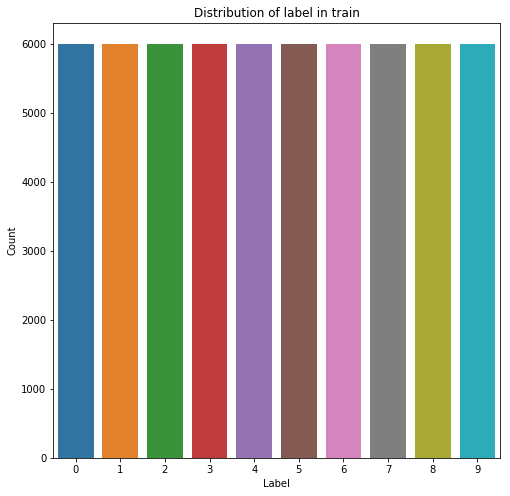

In [11]:
### distribution of class lables in train:

plt.figure(figsize=(8,8))
sns.countplot(train['label'])
plt.title("Distribution of label in train")
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

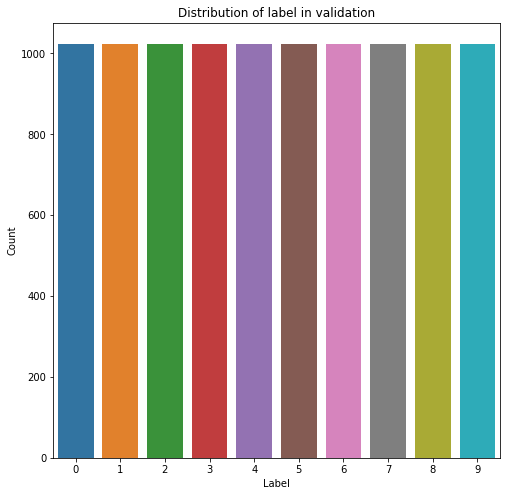

In [12]:
plt.figure(figsize=(8,8))
sns.countplot(digits['label'])
plt.title("Distribution of label in validation")
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [13]:
## Transforms:

train_transform=transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(0.3),
    transforms.ToTensor()
])
test_transform=transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(0.3),
    transforms.ToTensor()
])

In [14]:
class KannadaMNIST(Dataset):
    def __init__(self,images,data=None,transform=transforms.Compose([transforms.ToTensor()])):
        self.data=data
        self.images=images
        self.transform=transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,i):
        item=self.images.iloc[i]
        image=item[1:].values.astype(np.uint8).reshape(28,28,1)
        image=self.transform(image)
        if self.data is not None:
            label=item[0]
            return image,label
        else:
            return image

In [15]:
train_dataset=KannadaMNIST(train,'Train',transform=train_transform)
valid_dataset=KannadaMNIST(digits,'Valid',transform=test_transform)
test_dataset=KannadaMNIST(test,transform=test_transform)

In [16]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
valid_loader=DataLoader(valid_dataset,batch_size=32,shuffle=True)

In [17]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(f'Batch Image shape {images.shape}')

print(images[1].numpy().transpose((1,2,0)).shape)
print(labels[1].item())

Batch Image shape torch.Size([32, 1, 28, 28])
(28, 28, 1)
2


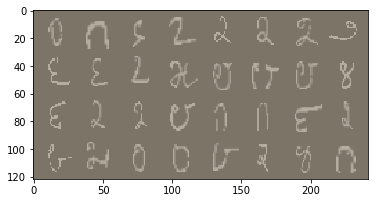

In [18]:
## Creating a simple nnet model:
##https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) ## changing the shape of the image.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
    
inputs,classes=next(iter(train_loader))
out=torchvision.utils.make_grid(inputs)

imshow(out)

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [20]:
### Building the model:

class nnet(nn.Module):
    def __init__(self):
        super(nnet,self).__init__()
        self.conv1=nn.Conv2d(in_channels=1,out_channels=32,kernel_size=5,padding=2) # (28,28,32)
        self.conv1_bn=nn.BatchNorm2d(num_features=32) #
        self.pool1=nn.MaxPool2d(kernel_size=2,stride=2) #(14,14,32)
        
        self.conv2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5,padding=2) # (14,14,64)
        self.conv2_bn=nn.BatchNorm2d(num_features=64)
        self.conv3=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=5,padding=2) #(14,14,128)
        self.pool2=nn.AvgPool2d(kernel_size=2,stride=2) # (7,7,128)
        
        self.fc1=nn.Linear(in_features=7*7*128,out_features=1024)
        self.fc1_batchnorm=nn.BatchNorm1d(num_features=1024)
        self.dropout=nn.Dropout(0.5)
        self.out=nn.Linear(in_features=1024,out_features=10)
        
    def forward(self,x):
        x=self.pool1(F.relu(self.conv1_bn(self.conv1(x))))
        x=self.pool2(F.relu(self.conv3(self.conv2_bn(self.conv2(x)))))
        #print(x.shape)
        x=x.view(-1,7*7*128)
        x=F.relu(self.fc1_batchnorm(self.fc1(x)))
        x=self.dropout(x)
        x=self.out(x)
        return(x)
        

In [21]:
model=nnet().to(device)

In [22]:

optimizer=optim.Adam(model.parameters(),lr=0.001)


In [23]:
n_epochs = 15
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)

    train_loss = []

    for batch_i, (data, target) in enumerate(train_loader):
        #print(batch_i)
        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}')

Mon Oct 28 03:40:02 2019 Epoch: 1
Epoch 1, train loss: 0.0721
Mon Oct 28 03:40:47 2019 Epoch: 2
Epoch 2, train loss: 0.0357
Mon Oct 28 03:41:31 2019 Epoch: 3
Epoch 3, train loss: 0.0301
Mon Oct 28 03:42:15 2019 Epoch: 4
Epoch 4, train loss: 0.0248
Mon Oct 28 03:42:59 2019 Epoch: 5
Epoch 5, train loss: 0.0209
Mon Oct 28 03:43:43 2019 Epoch: 6
Epoch 6, train loss: 0.0189
Mon Oct 28 03:44:26 2019 Epoch: 7
Epoch 7, train loss: 0.0159
Mon Oct 28 03:45:10 2019 Epoch: 8
Epoch 8, train loss: 0.0154
Mon Oct 28 03:45:53 2019 Epoch: 9
Epoch 9, train loss: 0.0108
Mon Oct 28 03:46:37 2019 Epoch: 10
Epoch 10, train loss: 0.0136
Mon Oct 28 03:47:20 2019 Epoch: 11
Epoch 11, train loss: 0.0097
Mon Oct 28 03:48:05 2019 Epoch: 12
Epoch 12, train loss: 0.0103
Mon Oct 28 03:48:48 2019 Epoch: 13
Epoch 13, train loss: 0.0086
Mon Oct 28 03:49:31 2019 Epoch: 14
Epoch 14, train loss: 0.0101
Mon Oct 28 03:50:15 2019 Epoch: 15
Epoch 15, train loss: 0.0092


In [24]:
#https://www.kaggle.com/bonhart/pytorch-cnn-from-scratch
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model on the 10240 validation images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model on the 10240 validation images: 78.310546875 %


In [25]:
test_loader=DataLoader(test_dataset,shuffle=False)

In [26]:
predict = []
model.eval() ## weighted mean and variance will be used in batch norm for test
for i, (data) in enumerate(test_loader):
    data = data.cuda()
    output = model(data)  
    output = output.cpu().detach().numpy()    
    predict.append(output[0])

In [27]:
sample_submission.head()

,id,label
0,0,5
1,1,5
2,2,5
3,3,5
4,4,5


In [28]:
sample_submission['label']=np.argmax(predict,axis=1)

In [29]:
sample_submission.to_csv('submission.csv',index=False)